In [1]:
import copy
import time
import os
# sys.path.append(os.pardir)
# sys.path.append(os.path.join(os.pardir, os.pardir))
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from math import floor

from torchsummary import summary
from typing import Union
from torch.utils.data import Subset
from tqdm import tqdm
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from src.datasets import read_pickled_dataset
from src.visualization import (calculate_statistics, play_audio, plot_mfccs,
                               plot_specgram, plot_waveform,
                               visualize_random_sample)
from src.audio_utils import split_waveform, CepstralNormalization

/home/renzo/anaconda3/envs/dl-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Librispeech Dataset

In [2]:
speaker_mfcc_db, mfcc_channel_db = read_pickled_dataset("librispeech-mixed") 
speaker_mfcc_db = speaker_mfcc_db.reset_index(drop=True)
# options: "librispeech-train-clean-100", "librispeech-train-other-500", "librispeech-mixed", "voxceleb1identification-4s"


 Loaded librispeech-mixed


Count number of unique speakers

In [3]:
len(np.unique(speaker_mfcc_db["speaker_id"]))

1166

Count the number of samples for each speaker_id

In [4]:
speaker_mfcc_db.groupby('speaker_id').size().sort_values()

speaker_id
449     33
421     42
680     50
689     61
974     66
      ... 
173    691
114    693
70     693
21     695
237    695
Length: 1166, dtype: int64

Text(0, 0.5, 'number of saples')

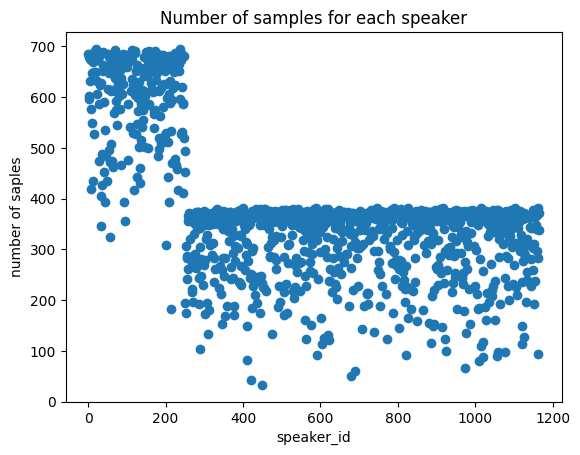

In [5]:
plt.scatter(speaker_mfcc_db.groupby('speaker_id').size().sort_values().index, speaker_mfcc_db.groupby('speaker_id').size().sort_values().values)
plt.title('Number of samples for each speaker')
plt.xlabel('speaker_id')
plt.ylabel('number of saples')

**We can decide what speaker_ids to keep in our dataset based on the number of samples**.

e.g. if we want at least 100 samples per speaker to have enough for training, validation, test (60, 20, 20)

In [6]:
min_num_samples = 100
speaker_mfcc_db_subset = speaker_mfcc_db[speaker_mfcc_db["speaker_id"].isin(speaker_mfcc_db.groupby('speaker_id').size()[speaker_mfcc_db.groupby('speaker_id').size() >= min_num_samples].index)]
number_speaker_ids = len(np.unique(speaker_mfcc_db_subset["speaker_id"]))

print(f"{number_speaker_ids} speakers in this subset, each with at least {min_num_samples} samples")

1152 speakers in this subset, each with at least 100 samples


In [7]:
mfcc_ids_subset = speaker_mfcc_db_subset["mfcc_id"].values
mfcc_channel_db_subset = mfcc_channel_db[mfcc_channel_db.index.isin(mfcc_ids_subset)]

In [8]:
speaker_mfcc_db_subset.shape, mfcc_channel_db_subset.shape

((438170, 2), (438170, 13))

## Preprocessing

In [9]:
def speaker_encoder(speaker_ids):
    """
    Creates a dictionary of (speaker_id, encoded_id) pairs
    """
    speaker_dict = {}
    for i, speaker_id in enumerate(speaker_ids):
        speaker_dict[speaker_id] = i
    return speaker_dict

In [10]:
class MFCCData(Dataset):
    def __init__(self, speaker_mfcc_db, mfcc_channel_db, transform=None):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        Inputs
        ------
        speaker_mfcc_db : pd.DataFrame
            dataframe of (index, speaker_id, mfcc_id)
            
        mfcc_channel_db : pd.DataFrame
            dataframe of (mfcc_id, channel_1, channel_2, ...)
            
        transform : optional 
            transformations to perform on the MFCCs
        """
        self.speaker_mfcc_db = speaker_mfcc_db
        self.mfcc_channel_db = mfcc_channel_db        
        self.transform = transform
            
    def __len__(self):
        return len(self.speaker_mfcc_db)

    def __getitem__(self, idx):
        speaker_id = self.speaker_mfcc_db.iloc[idx]['speaker_id']
        mfcc_id = self.speaker_mfcc_db.iloc[idx]['mfcc_id']
        
        mfcc = []
        for i, col in enumerate(self.mfcc_channel_db.columns):
            mfcc_channel_i = self.mfcc_channel_db.loc[mfcc_id, f'channel_{i}']
            mfcc.append(mfcc_channel_i)
            
        mfcc = np.asarray(mfcc)
        mfcc = mfcc.reshape(len(self.mfcc_channel_db.columns), -1)
        
        if self.transform:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            mfcc = np.transpose(mfcc, [1, 2, 0])
            mfcc = self.transform(mfcc)
            
        else:
            mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1])
            
        speaker_id = torch.tensor(speaker_id) 
        mfcc = torch.tensor(mfcc) 
            
        if torch.cuda.is_available():
            speaker_id = speaker_id.to('cuda')
            mfcc = mfcc.to('cuda')
            
        return mfcc, speaker_id

In [11]:
def split_train_test_val(speaker_mfcc_db, train_pct, val_pct, 
                         test_pct):
    """
    Splits the dataset into train, validation, and test. This function returns the indices of the dataframe corresponding
    to each set
    """
    train_ids = []
    val_ids = []
    test_ids = []
    
    for speaker_id in np.unique(speaker_mfcc_db["speaker_id"].values):
        mfcc_ids = speaker_mfcc_db[speaker_mfcc_db["speaker_id"]==speaker_id]["mfcc_id"].sample(frac=1).tolist()
        len_ids = len(mfcc_ids)
        
        train_ids.extend(mfcc_ids[:floor(len_ids * train_pct)])
        val_ids.extend(mfcc_ids[floor(len_ids * train_pct):floor(len_ids * (train_pct + val_pct))])
        test_ids.extend(mfcc_ids[floor(len_ids * (train_pct + val_pct)):])
    
    return train_ids, val_ids, test_ids

In [12]:
def get_datasets(speaker_mfcc_db, mfcc_channel_db, speaker_dict, window_size, sample_rate , train_pct , 
                 val_pct , test_pct , number_spectral_coefficients , cepstral_normalize , 
                 transform=None):
    """
    Wrapper around other functions to create datasets
    
    Inputs
    -----
    
    speaker_dict : dict
        dictionary of {'speaker_id':encoded_id} pairs          

    window_size : int
        window size to be used to consistently split waveforms

    sample_rate : int
        sample rate in kHz

    train_pct : float
        train percentage
    
    val_pct : float
        validation percentage

    test_pct : float
        Test percentage

    number_spectral_coefficients : int
        number of spectral coefficients to keep for the MFCC calculation
        
    normalize : bool
        whether to apply cepstral normalization
        
    transform : 
        a custom transformation to apply to the dataset
        
    Returns
    -------
    
    mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test
    
    """
    speaker_mfcc_db["speaker_id"] = speaker_mfcc_db["speaker_id"].replace(speaker_dict)
    
    mfcc_channel_db = mfcc_channel_db.reset_index(names="speaker_id")
    mfcc_channel_db["speaker_id"] = mfcc_channel_db["speaker_id"].replace(speaker_dict)
    mfcc_channel_db.set_index('speaker_id', inplace=True)
    
    train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db, train_pct, val_pct, test_pct)
    
    # speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
    # speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
    # speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]
    
    speaker_mfcc_db_train = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(train_ids)]
    speaker_mfcc_db_val = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(val_ids)]
    speaker_mfcc_db_test = speaker_mfcc_db[speaker_mfcc_db["mfcc_id"].isin(test_ids)]
    
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train["mfcc_id"].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val["mfcc_id"].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test["mfcc_id"].values]
    
    if cepstral_normalize:
        cepstral_normalization = CepstralNormalization(number_spectral_coefficients)
        cepstral_normalization.fit(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_train = cepstral_normalization.transform(speaker_mfcc_db_train['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_val = cepstral_normalization.transform(speaker_mfcc_db_val['mfcc_id'].values, mfcc_channel_db)
        normalized_mfcc_channel_db_test = cepstral_normalization.transform(speaker_mfcc_db_test['mfcc_id'].values, mfcc_channel_db)
        mfcc_channel_db = pd.concat([normalized_mfcc_channel_db_train, normalized_mfcc_channel_db_val, normalized_mfcc_channel_db_test])
        
    mfcc_channel_db_train = mfcc_channel_db.loc[speaker_mfcc_db_train['mfcc_id'].values]
    mfcc_channel_db_val = mfcc_channel_db.loc[speaker_mfcc_db_val['mfcc_id'].values]
    mfcc_channel_db_test = mfcc_channel_db.loc[speaker_mfcc_db_test['mfcc_id'].values]
    
    mfcc_dataset_train = MFCCData(speaker_mfcc_db_train, mfcc_channel_db_train, transform=transform)
    mfcc_dataset_val = MFCCData(speaker_mfcc_db_val, mfcc_channel_db_val, transform=transform)
    mfcc_dataset_test = MFCCData(speaker_mfcc_db_test, mfcc_channel_db_test, transform=transform)

    return mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test

In [13]:
# preprocessing parameters
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

train_pct = 0.60
val_pct = 0.20
test_pct = 0.20
number_spectral_coefficients = 13
cepstral_normalize = True

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(224, 224))]) 

speaker_dict = speaker_encoder(np.unique(speaker_mfcc_db['speaker_id']))


In [14]:
speaker_mfcc_db_subset.shape, mfcc_channel_db_subset.shape

((438170, 2), (438170, 13))

In [15]:
# speaker_mfcc_db_subset["speaker_id"] = speaker_mfcc_db_subset["speaker_id"].replace(speaker_dict)
    
# mfcc_channel_db_subset = mfcc_channel_db_subset.reset_index(names="speaker_id")
# mfcc_channel_db_subset["speaker_id"] = mfcc_channel_db_subset["speaker_id"].replace(speaker_dict)
# mfcc_channel_db_subset.set_index('speaker_id', inplace=True)

# train_ids, val_ids, test_ids = split_train_test_val(speaker_mfcc_db_subset, train_pct, val_pct, test_pct)

# # speaker_mfcc_db_train = speaker_mfcc_db.loc[train_ids]
# # speaker_mfcc_db_val = speaker_mfcc_db.loc[val_ids]
# # speaker_mfcc_db_test = speaker_mfcc_db.loc[test_ids]

# speaker_mfcc_db_train = speaker_mfcc_db_subset[speaker_mfcc_db_subset["mfcc_id"].isin(train_ids)]
# speaker_mfcc_db_val = speaker_mfcc_db_subset[speaker_mfcc_db_subset["mfcc_id"].isin(val_ids)]
# speaker_mfcc_db_test = speaker_mfcc_db_subset[speaker_mfcc_db_subset["mfcc_id"].isin(test_ids)]

# mfcc_channel_db_train = mfcc_channel_db_subset.loc[speaker_mfcc_db_train["mfcc_id"].values]
# mfcc_channel_db_val = mfcc_channel_db_subset.loc[speaker_mfcc_db_val["mfcc_id"].values]
# mfcc_channel_db_test = mfcc_channel_db_subset.loc[speaker_mfcc_db_test["mfcc_id"].values]

In [16]:
mfcc_dataset_train, mfcc_dataset_val, mfcc_dataset_test = get_datasets(speaker_mfcc_db.copy(), mfcc_channel_db.copy(),
                                                speaker_dict=speaker_dict,
                                                window_size=window_size, 
                                                sample_rate=sample_rate, 
                                                train_pct=train_pct,
                                                val_pct=val_pct,
                                                test_pct=test_pct,
                                                number_spectral_coefficients=number_spectral_coefficients,
                                                cepstral_normalize=cepstral_normalize,
                                                transform=transform,
                                                )

Normalizing...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:40<00:00,  3.15s/it]


In [17]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mfcc_dataset_test, batch_size=batch_size, shuffle=False)

In [18]:
train_subset = Subset(mfcc_dataset_train, range(0, mfcc_dataset_train.__len__(), 1000))
val_subset = Subset(mfcc_dataset_val, range(0, mfcc_dataset_val.__len__(), 1000))

In [19]:
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)

In [20]:
def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_epoch = 0
    val_acc = []

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            mfcc, speakers = data
            outputs = model(mfcc)

            loss = criterion(outputs, speakers)
            total_loss += loss.item()
            total_epoch += len(speakers)
            val_acc.append(get_accuracy(model, loader))

        loss = float(total_loss) / (i + 1)
        val_acc = np.mean(val_acc)
    return loss, val_acc

def get_accuracy(model, dataloader):
    #select index with maximum prediction score
    correct = 0
    total = 0
    for data in dataloader:
        mfcc, labels = data
        output = model(mfcc)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

def train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=2, plot_loss=True):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
        
    if torch.cuda.is_available():
        model = model.to(torch.device('cuda:0'))
    
    for epoch in tqdm(range(num_epochs)): 
        total_train_loss = 0.0
        total_epoch = 0
        total_train_acc = []
        correct = 0.0
        total = 0.0
        
        model.train()
        
        for i, data in enumerate(train_loader):
            mfcc, speakers = data
                        
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = model(mfcc)
            loss = criterion(outputs, speakers)
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(speakers)
            total_train_acc.append(get_accuracy(model, train_loader))
            
        model.eval()
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_acc[epoch] = np.mean(total_train_acc)        
        val_loss[epoch], val_acc[epoch] = evaluate(model, val_loader, criterion)
        
        if epoch % print_every == 0:    
            print(f"Epoch {epoch}: \n \
            Train loss {train_loss[epoch]:.3f} | Val loss {val_loss[epoch]:.3f} \n \
            Train acc {train_acc[epoch]:.3f} | Val acc {val_acc[epoch]:.3f} \n")
            
            
    if plot_loss:
        n = len(train_loss) # number of epochs
        plt.figure()
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,n+1), train_loss, label="Train")
        plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')

        plt.figure()
        plt.title("Train vs Validation Accuracy")
        plt.plot(range(1,n+1), train_acc, label="Train")
        plt.plot(range(1,n+1), val_acc, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')   

In [21]:
class CNN(nn.Module):
    def __init__(self, hidden_layers, output_size):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(1 * 13 * 126, hidden_layers)
        self.fc2 = nn.Linear(hidden_layers, output_size)

    def forward(self, x):
        x = x.float()
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = x.view(-1, 1 * 13 * 126)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 1152, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=8, stride=4, padding=2),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.RReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.RReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [23]:
# model hyperparameters
output_size = len(np.unique(speaker_mfcc_db['speaker_id']))
lr = 0.01
num_epochs = 30

# model = CNN(hidden_layers=hidden_layers, output_size=output_size)
model = CustomNet(num_classes=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, momentum=momentum)
num_epochs = num_epochs

In [24]:
for data, labels in train_loader:
    # print(max(labels))
    break

/tmp/ipykernel_511214/1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


In [25]:
# train_model(model, train_loader, val_loader, batch_size, num_epochs, criterion, optimizer, print_every=1)

In [26]:
# Define Optimizer and Loss Function

def train_and_validate(model, epochs=25, batch_size = 10, lr=1e-3):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    loss_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mfcc_dataset_val, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)
                
                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/subset_train_size 
        avg_train_acc = train_acc/subset_train_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/subset_val_size 
        avg_valid_acc = valid_acc/subset_val_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [27]:
#Custom Net Class
class CustomNet(nn.Module):
    def __init__(self, num_classes: int = 251, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=4, padding=2),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 384, kernel_size=5, padding=2),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            nn.RReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
output_size = len(np.unique(speaker_mfcc_db['speaker_id']))

net = CustomNet(num_classes = output_size)
net = net.to('cuda')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


trained_model, history = train_and_validate(net, epochs=10, batch_size = 64, lr=1e-4)

Epoch: 1/10


/tmp/ipykernel_511214/1364449930.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mfcc = torch.tensor(mfcc)


In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []
ep = []
i = 0
for tloss,vloss, tacc, vacc in history:
    train_acc.append(tacc)
    val_acc.append(vacc)
    train_loss.append(tloss)
    val_loss.append(vloss)
    ep.append(i)
    i += 1


n = len(train_loss) # number of epochs
plt.figure()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
# plt.show()

plt.figure()
plt.title("Train vs Validation Accuracy")
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')

In [ ]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            mfcc, speakers = data
            outputs = model(mfcc)
            _, predicted = torch.max(outputs.data, 1)
            total += speakers.size(0)
            correct += (predicted == speakers).sum().item()

    print(f'Accuracy: {100 * correct // total} %')

In [ ]:
test_model(net, test_loader)